# Fresh or Rotten? AI-Powered Fruit Quality Inspector

## Project Description: 

In the age of intelligent automation, ensuring food quality has never been more critical—especially across agriculture and retail sectors. This project focuses on leveraging transfer learning to extract meaningful features from fruit images and applying tree-based machine learning models to classify fruits as either fresh or rotten.

Pre-trained convolutional neural networks such as ResNet50V2, DenseNet121, and MobileNetV2 are utilized not for direct classification, but as feature extractors—capturing high-level representations from fruit images. These deep feature embeddings are then fed into tree-based classifiers like Extra Trees, Random Forest, and Gradient Boosting, which are known for their robustness and interpretability in handling structured feature data.

To promote trust and transparency in AI-driven decisions, this project integrates explainable AI (XAI) techniques. Model-agnostic tools such as LIME (Local Interpretable Model-agnostic Explanations) and SHAP (SHapley Additive exPlanations) are employed to highlight which parts of the input image most influenced the model's prediction—bridging the gap between black-box models and human understanding.

The final output is an intuitive Streamlit web application that allows users to:

- Upload fruit images,

- View real-time classification results,

- Explore visual explanations of model predictions.

## Project Objective:

- To build a robust fruit quality classification model using transfer learning with pre-trained architectures (ResNet50V2, ResNet101V2, and MobileNetV2).

- To compare model performance and identify the most accurate and computationally efficient architecture.

- To enhance model interpretability by integrating explainable AI techniques such as LIME or SHAP (excluding Grad-CAM).

- To develop an interactive and user-friendly Streamlit web application.



In [ ]:
# import relevant libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import ResNet50V2, DenseNet121, MobileNetV2 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [73]:
# data augmentation for training
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 10, 
                                   horizontal_flip = True, 
                                   zoom_range = 0.2, 
                                   vertical_flip = True, 
                                   shear_range = 0.2)

valtest_datagen = ImageDataGenerator(rescale = 1./255)

In [74]:
# load datasets

img_width, img_height = 224, 224
batch_size = 32

train_dir = "datasets/train"
val_dir = "datasets/valid"
test_dir = "datasets/test"


train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (img_width, img_height), 
                                                    batch_size = batch_size,
                                                    class_mode = "binary", 
                                                    color_mode = "rgb", 
                                                    seed = 2025, 
                                                    shuffle = False)

val_generator = valtest_datagen.flow_from_directory(val_dir, 
                                                    target_size = (img_width, img_height), 
                                                    class_mode = "binary", 
                                                    color_mode = "rgb", 
                                                    seed = 2025, 
                                                    shuffle = False)

test_generator = valtest_datagen.flow_from_directory(test_dir, 
                                                    target_size = (img_width, img_height), 
                                                    class_mode = "binary", 
                                                    color_mode = "rgb", 
                                                    seed = 2025, 
                                                    shuffle = False)

Found 287 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


## ResNet50V2 + Extra-Trees Classifier

### Feature Extraction using ResNet50V2

In [ ]:
# load pre-trained model, max pooling output
resnet_model = ResNet50V2(weights = "imagenet", include_top = False, pooling = "max", input_shape = (img_width, img_height, 3))

In [76]:
# feature extraction 
X_train = resnet_model.predict(train_generator, verbose = 1)
X_test = resnet_model.predict(test_generator, verbose = 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


In [77]:
# labels 
y_train = train_generator.classes
y_test = test_generator.classes

### Fine-Tuning on Extra Trees Classifier

In [84]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2025)

In [115]:
# define params 
params = {'n_estimators': np.arange(50, 150, 10), 
          'criterion': ['gini', 'entropy', 'log_loss'], 
          'max_depth': [10, 11, 12, 13, 14, 15]}

# define grid search 
resnet_etc_gs = GridSearchCV(estimator = ExtraTreesClassifier(random_state = 2025), 
                             param_grid = params,
                             scoring = "accuracy", 
                             n_jobs = 1, 
                             refit = True, 
                             cv = cv, 
                             verbose = 3, 
                             return_train_score = True)
# fit the model
resnet_etc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END criterion=gini, max_depth=10, n_estimators=50;, score=(train=1.000, test=0.759) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, n_estimators=50;, score=(train=1.000, test=0.879) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, n_estimators=50;, score=(train=1.000, test=0.825) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, n_estimators=50;, score=(train=1.000, test=0.895) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, n_estimators=50;, score=(train=1.000, test=0.965) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, n_estimators=60;, score=(train=1.000, test=0.776) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, n_estimators=60;, score=(train=1.000, test=0.862) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, n_estimators=60;, score=(train=1.000, test=0.860) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2025, shuffle=True),
             estimator=ExtraTreesClassifier(random_state=2025), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 11, 12, 13, 14, 15],
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
             return_train_score=True, scoring='accuracy', verbose=3)

In [116]:
# print the best hyperparameters and best scores 
print("The best score: {:.4f}".format(resnet_etc_gs.best_score_))
print("The best hyperparameters: {}".format(resnet_etc_gs.best_estimator_))

The best score: 0.9199
The best hyperparameters: ExtraTreesClassifier(max_depth=14, n_estimators=np.int64(130),
                     random_state=2025)


In [125]:
# perform prediction on test set 
resnet_etc_predict = resnet_etc_gs.predict(X_test)

In [126]:
# print classification report
print(classification_report(y_test, resnet_etc_predict))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



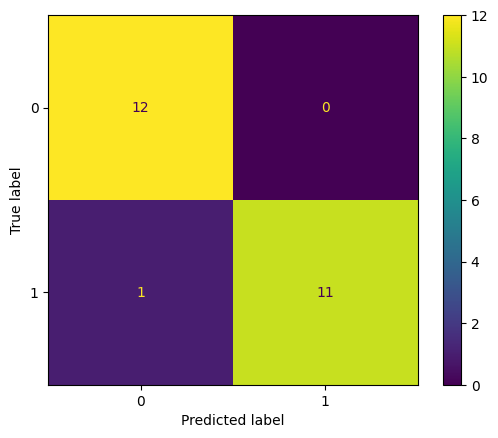

In [129]:
# confusion matrix
resnet_etc_cm = confusion_matrix(y_test, resnet_etc_predict)
resnet_etc_cm_display = ConfusionMatrixDisplay(resnet_etc_cm)
resnet_etc_cm_display.plot()
plt.show()

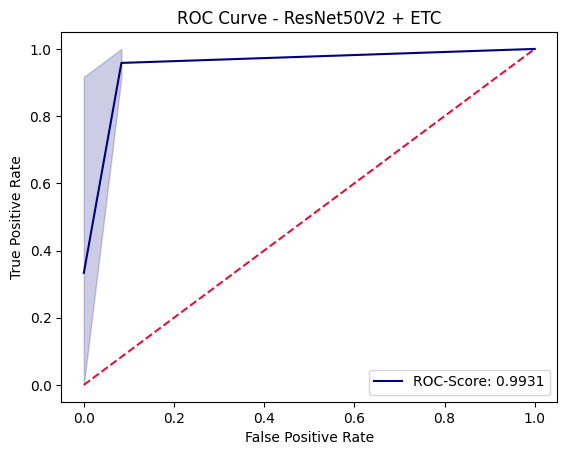

In [137]:
# predict probabilities of the positive class
resnet_etc_y_probs = resnet_etc_gs.predict_proba(X_test)[:, 1]
resnet_etc_fpr, resnet_etc_tpr, threshold = roc_curve(y_test, resnet_etc_y_probs)
resnet_etc_auc_score = roc_auc_score(y_test, resnet_etc_y_probs)

sns.lineplot(x = resnet_etc_fpr, y = resnet_etc_tpr, color = "navy", label = "ROC-Score: {:.4f}".format(resnet_etc_auc_score))
sns.lineplot(x = [0, 1], y = [0, 1], color = "crimson", linestyle = "--")
plt.title("ROC Curve - ResNet50V2 + ETC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()